In [2]:
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

In [3]:
def trans(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) * 255
    return inp

In [ ]:
def write_pred(args, model, dataloader, use_gpu):
    meta = pd.io.excel.read_excel(args.meta_path)
    
    pred_settled = pd.DataFrame(columns = list(meta.columns.values) + ['pred'])
    pred_unsettled = pd.DataFrame(columns = list(meta.columns.values) + ['pred'])
    settled = 0
    unsettled = 0
    
    model.train(False)
    model.eval()
    
    # hook the feature extractor
    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())
    # get the softmax weight
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].cpu().data.numpy())
    
    for inputs in tqdm(dataloader):
        features_blobs = []
        model._modules.get('features').register_forward_hook(hook_feature)
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)

        m = nn.Softmax(dim = 1)
        outputs = m(model(inputs)) 
        outputs = (outputs.data).cpu().numpy()
        preds = np.argsort(outputs, 1)[:,-1:]

        for i in range(preds.shape[0]):
            curr = meta.loc[settled + unsettled]
            curr['pred'] = preds[i,-1]

            conf = outputs[i, preds[i,-1]]           
            if conf > args.threshold:
                settled += 1
                pred_settled.loc[settled] = curr 
            else:
                unsettled += 1
                pred_unsettled.loc[unsettled] = curr
                
                # generate CAM
                CAMs = returnCAM(features_blobs[0][i], weight_softmax, [preds[i]])
                img = inputs.cpu().data[i]
                heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(224, 224)), cv2.COLORMAP_JET)
                img = trans(img)
                org=img.astype(np.uint8)
                org_fig = cv2.cvtColor(org, cv2.COLOR_RGB2BGR)
                result = heatmap * 0.3 + org_fig * 0.5
                cv2.imwrite('CAM' + str(unsettled) + '.jpg', result)
                
    pred_settled.to_csv('settled.csv', index = False)
    pred_unsettled.to_csv('unsettled.csv', index = False)

In [2]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (224, 224)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [ ]:
import sys
from PIL import Image

images = map(Image.open, ['Test1.jpg', 'Test2.jpg', 'Test3.jpg'])
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]

new_im.save('test.jpg')

In [4]:
import sys
from PIL import Image

In [6]:
images = map(Image.open, ['1.jpg', 'CAM1.jpg'])
widths, heights = zip(*(i.size for i in images))

In [8]:
total_width = sum(widths)
max_height = max(heights)

In [14]:
new = Image.new('RGB', (total_width, max_height))

In [24]:
new = Image.new('RGB', (total_width, max_height))
x_offset = 0
for im in map(Image.open, ['1.jpg', 'CAM1.jpg']):
  new.paste(im, (x_offset,0))
  x_offset += im.size[0]

new.save('test.jpg')

In [28]:
from PIL import ImageFont, ImageDraw, Image
test = Image.open('CAM1.jpg')
draw = ImageDraw.Draw(test)
draw.text((0, 0), "Your Text Here")

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

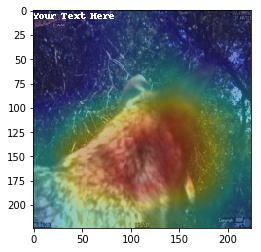

In [31]:
plt.imshow(test)

In [3]:
from PIL import Image,ImageDraw,ImageFont
import fontconfig

ModuleNotFoundError: No module named 'fontconfig'

In [ ]:
from PIL import Image,ImageDraw,ImageFont
import fontconfig

# find a font file
fonts = fontconfig.query(lang='en')
for i in range(1, len(fonts)):
    if fonts[i].fontformat == 'TrueType':
        absolute_path = fonts[i].file
        break
